<a href="https://colab.research.google.com/github/yecatstevir/farmer_market_food_insecurity/blob/main/src/Prediction/predictive_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predictive Modeling using Machine Learning
Author : Stacey Beck


Questions we want to answer:
- Likelihood of having a farmers' market or any market


In [2]:
# Mount Google Drive to notebook
from google.colab import drive, files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd
from numpy import loadtxt
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import seaborn as sns

from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report



In [4]:
# Load the data
updated_df = pd.read_csv('/content/gdrive/MyDrive/FIS/team20_clean_MM_FA_FM_county_2gdp.csv')#/content/gdrive/MyDrive/FIS/updated_team20_clean_MM_FA_FM_county_202207231508.csv')

# Create Ground Truth Labels
updated_df.loc[updated_df['count_FM'] > 0, 'If FM'] = 1
updated_df.loc[updated_df['count_FM'] <= 0, 'If FM'] = 0
updated_df.loc[updated_df['count_OFM'] > 0, 'If OFM'] = 1
updated_df.loc[updated_df['count_OFM'] <= 0, 'If OFM'] = 0
updated_df.loc[updated_df['count_CSA'] > 0, 'If CSA'] = 1
updated_df.loc[updated_df['count_CSA'] <= 0, 'If CSA'] = 0
updated_df['Total_Markets'] = updated_df['count_CSA'] + updated_df['count_OFM'] + updated_df['count_FM']
updated_df.loc[updated_df['Total_Markets'] > 0, 'If Any Market Type'] = 1
updated_df.loc[updated_df['Total_Markets'] <= 0, 'If Any Market Type'] = 0
updated_df = updated_df.dropna()

In [5]:
total_markets = updated_df['If Any Market Type'].sum()

In [6]:
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3056 entries, 0 to 3141
Data columns (total 54 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Unnamed: 0                                                          3056 non-null   int64  
 1   FIPS                                                                3056 non-null   int64  
 2   State                                                               3056 non-null   object 
 3   2019 Food Insecurity Rate                                           3056 non-null   float64
 4   # of Food Insecure Persons in 2019                                  3056 non-null   int64  
 5   Low Threshold in state                                              3056 non-null   int64  
 6   Low Threshold Type                                                  3056 non-null   object 
 7   High Threshold 

In [7]:
# Creating more features if we want to use them as ground truth later
updated_df['prob_market'] = updated_df['Total_Markets'] / updated_df['Total_Markets'].sum()
updated_df['prob_market_fm'] = updated_df['count_FM'] / updated_df['count_FM'].sum()
#updated_df['prob_market'] = updated_df['prob_market']/total_markets

In [8]:
updated_df.loc[updated_df['County'] == 'Santa Clara County']

,Unnamed: 0,FIPS,State,2019 Food Insecurity Rate,# of Food Insecure Persons in 2019,Low Threshold in state,Low Threshold Type,High Threshold in state,High Threshold Type,2019 Child food insecurity rate,...,lat,long,2019,If FM,If OFM,If CSA,Total_Markets,If Any Market Type,prob_market,prob_market_fm
228,228,6085,California,7.3,140120,200,"SNAP, Other Nutrition Programs",200,"SNAP, Other Nutrition Programs",6.5,...,37.220695,-121.69051,169.718,1.0,1.0,1.0,8.0,1.0,0.002245,0.005045


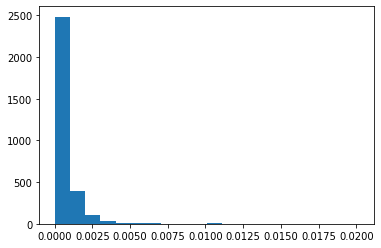

In [9]:
import matplotlib.pyplot as plt
plt.hist(updated_df['prob_market_fm'], bins = 20)
plt.show()

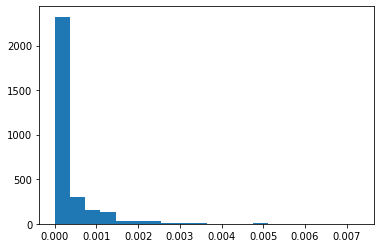

In [8]:
plt.hist(updated_df['prob_market'], bins = 20)
plt.show()

# Predict only FM

In [27]:
# If have FM


col_to_keep = [
'If FM',
#'count_OFM',
#'count_SNAP_participation_OFM', 
#'count_FNAP_participation_OFM',
#'count_WIC_participation_OFM', 
#'count_SFMNP_participation_OFM',
#'count_CSA', 
#'count_SNAP_participation_CSA',
#'count_FNAP_participation_CSA', 
#'count_WIC_participation_CSA',
#'count_SFMNP_participation_CSA', 
#'count_FM',
#'count_SNAP_participation_FM', 
#'count_FNAP_participation_FM',
#'count_WIC_participation_FM', 
#'count_SFMNP_participation_FM',
'2019 Food Insecurity Rate',
'# of Food Insecure Persons in 2019', 
'Low Threshold in state',
#'Low Threshold Type', 
'High Threshold in state', 
#'High Threshold Type',
'2019 Child food insecurity rate',
'# of Food Insecure Children in 2019',
'% food insecure children in HH w/ HH incomes below 185 FPL in 2019',
'% food insecure children in HH w/ HH incomes above 185 FPL in 2019',
'2019 Cost Per Meal', 
'2019 Weighted Annual Food Budget Shortfall',
'P_FI_Below_Low_Threshold', 
'P_FI_Between_Thresholds',
'P_FI_Above_High_Threshold', 
'TractSNAP', 
'TractHUNV', 
'TractKids', 
'TractSeniors', 
'lahunvhalf',
'LALOWI05_10', 
'PovertyRate', 
'lalowihalf', 
'TractLOWI', 
'Urban',
'MedianFamilyIncome',
'estimated_population',
'2019', 
'lat', 
'long'
] 

updated_df_col = updated_df[col_to_keep]

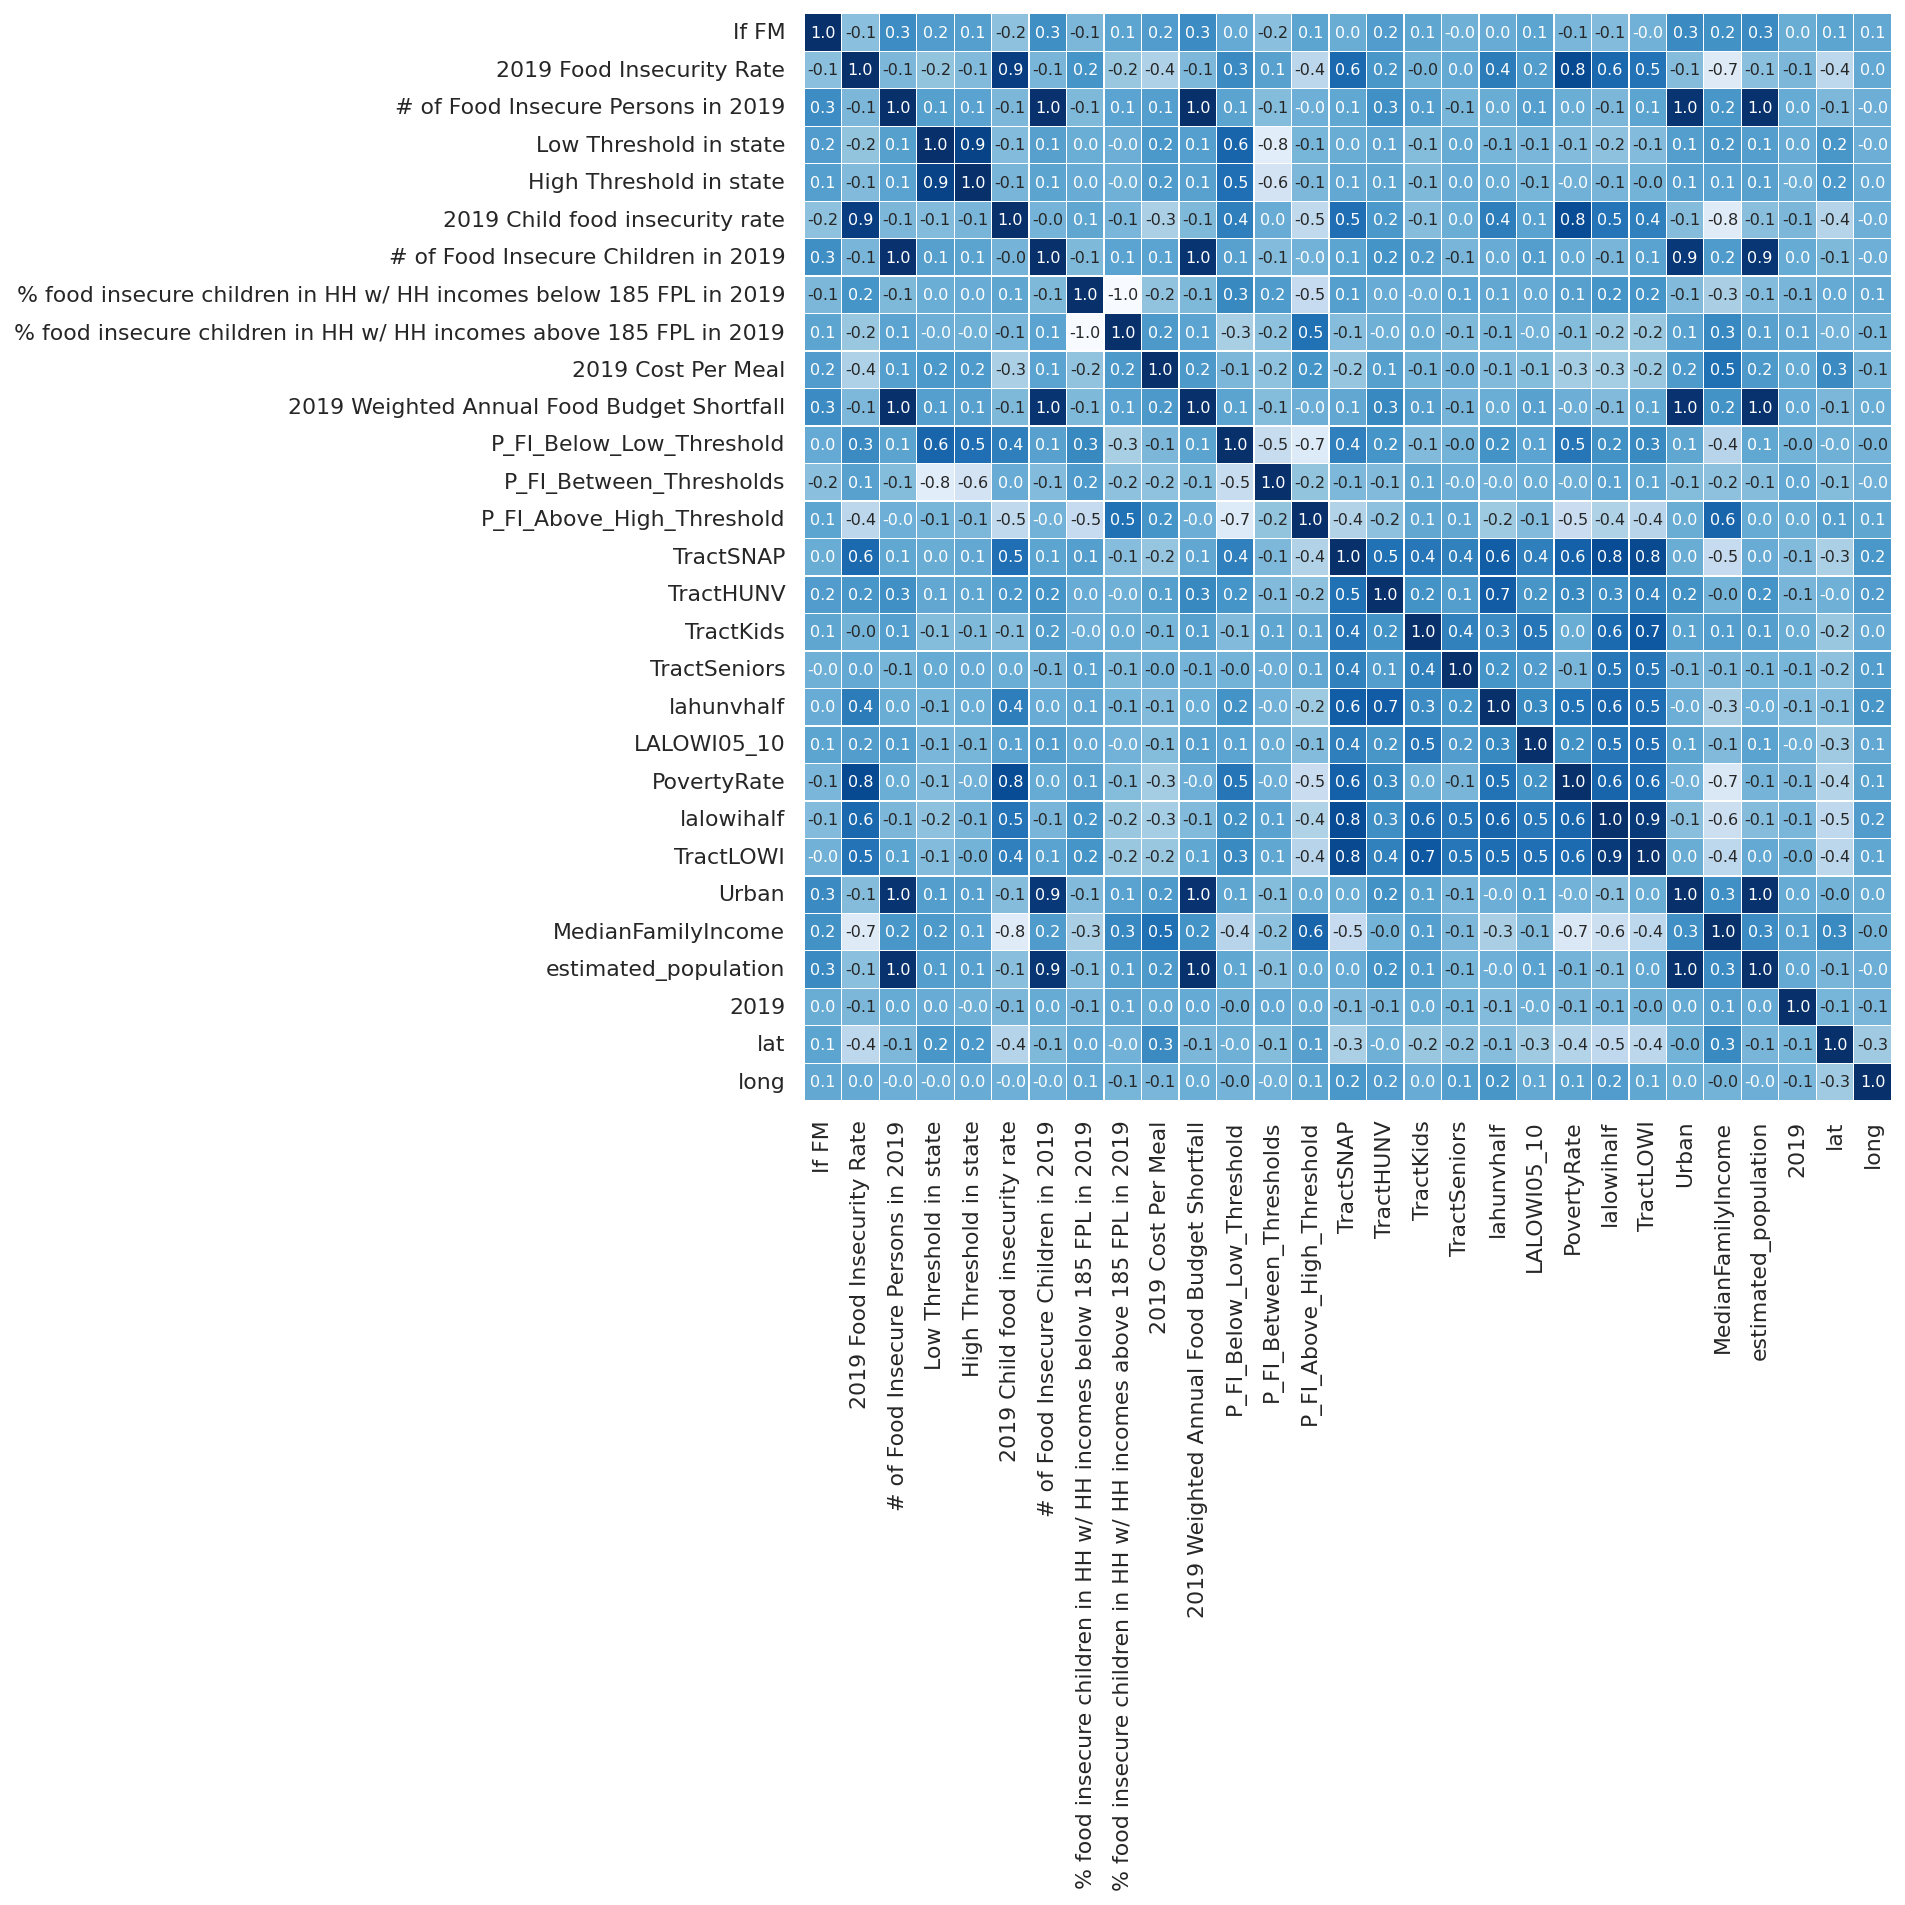

In [28]:
# Plot correlation matrix of all features
set_matplotlib_formats('retina')
plt.figure(figsize = (10,10))
sns.set_theme(style="white")

corr_mat = updated_df_col.corr()

sns.heatmap(corr_mat, cmap = 'Blues', linewidths=0.1,
            annot = True, cbar = False, square = True, fmt=".1f", annot_kws={"size":8})
plt.show()

### Check feature importance

[0.02147709 0.0359057  0.06483109 0.         0.02423189 0.0290258
 0.01823923 0.02863066 0.02473753 0.08196408 0.02298944 0.01730999
 0.01501248 0.02808375 0.02302487 0.02859592 0.02745598 0.02167136
 0.02570913 0.02183934 0.02499267 0.03058506 0.16786735 0.03314224
 0.10129958 0.01747021 0.03791277 0.02599487]


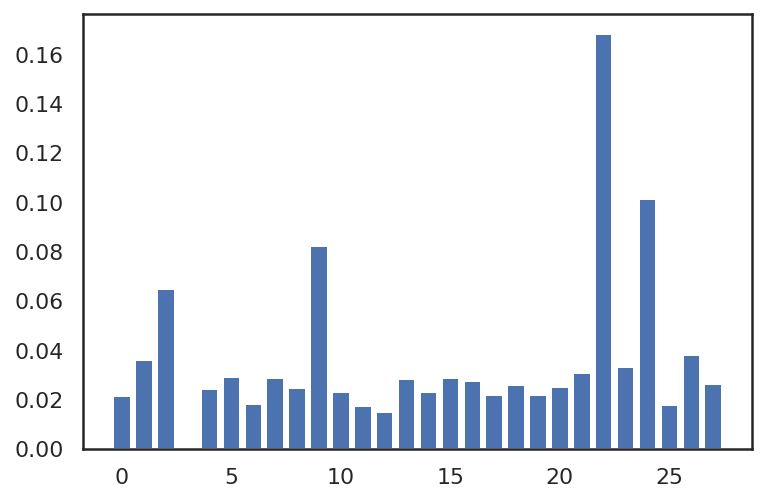

In [29]:
# Get X and Y
X = updated_df_col.iloc[:, 1:]
y = updated_df_col.iloc[0:,0]


# fit model no training data
model = XGBClassifier()
model.fit(X, y)
print(model.feature_importances_)

# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

<Figure size 576x576 with 0 Axes>

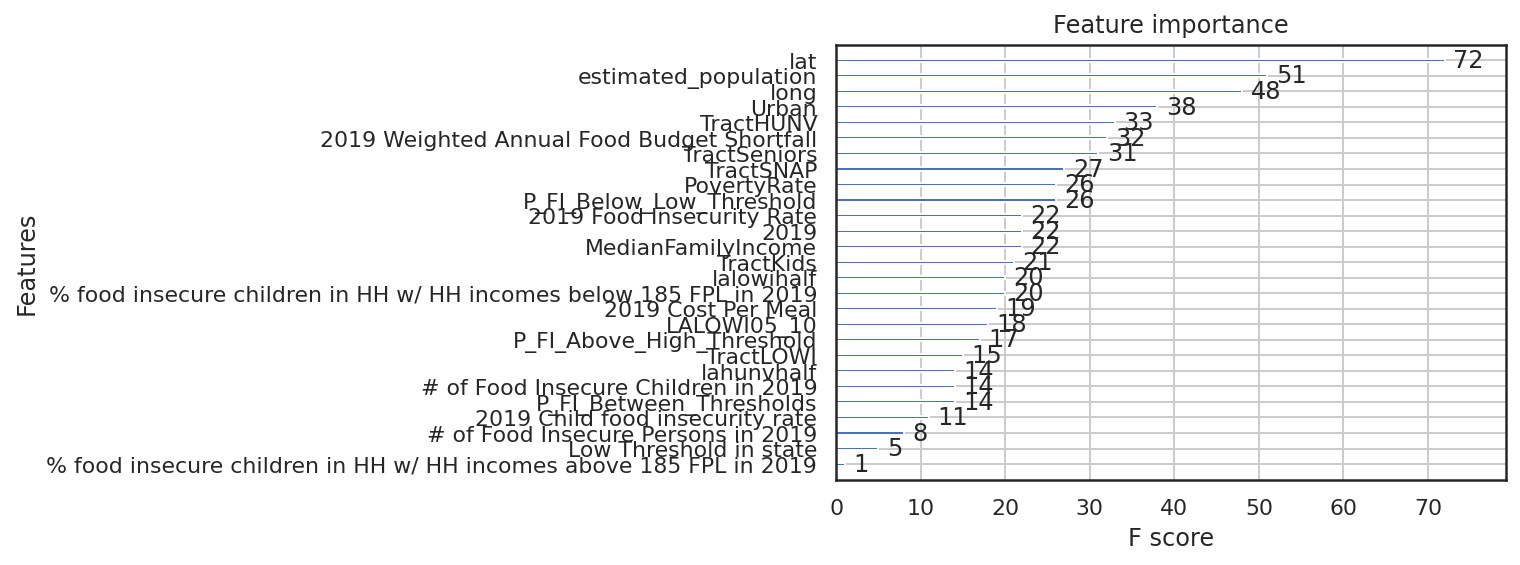

In [30]:
from xgboost import plot_importance
plt.figure(figsize = (8,8))
plot_importance(model)
plt.show()

## Grid Search best params

In [14]:
# Cross Validation
scaler = StandardScaler()
X = scaler.fit_transform(X)

n = [10, 50, 100]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate, n_estimators = n)

model = XGBClassifier()
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=24) # cross validate

# Grid search
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.394957 using {'learning_rate': 0.1, 'n_estimators': 50}
-0.692649 (0.000010) with: {'learning_rate': 0.0001, 'n_estimators': 10}
-0.690664 (0.000053) with: {'learning_rate': 0.0001, 'n_estimators': 50}
-0.688208 (0.000105) with: {'learning_rate': 0.0001, 'n_estimators': 100}
-0.688206 (0.000105) with: {'learning_rate': 0.001, 'n_estimators': 10}
-0.669382 (0.000521) with: {'learning_rate': 0.001, 'n_estimators': 50}
-0.647778 (0.001057) with: {'learning_rate': 0.001, 'n_estimators': 100}
-0.647603 (0.001055) with: {'learning_rate': 0.01, 'n_estimators': 10}
-0.528802 (0.004589) with: {'learning_rate': 0.01, 'n_estimators': 50}
-0.457460 (0.007961) with: {'learning_rate': 0.01, 'n_estimators': 100}
-0.454494 (0.008660) with: {'learning_rate': 0.1, 'n_estimators': 10}
-0.394957 (0.016712) with: {'learning_rate': 0.1, 'n_estimators': 50}
-0.399240 (0.018867) with: {'learning_rate': 0.1, 'n_estimators': 100}
-0.405790 (0.013853) with: {'learning_rate': 0.2, 'n_estimators': 10}
-0.

## Train model using best params

In [31]:
# split data into X and y
Xf = updated_df_col.iloc[:, 1:]
yf = updated_df_col.iloc[0:,0]


# split data into train and test sets
X_trainf, X_testf, y_trainf, y_testf = train_test_split(Xf, yf, test_size=0.20, random_state=7)

scaler = StandardScaler()
Xf = scaler.fit_transform(Xf)
X_trainf = scaler.fit_transform(X_trainf)
X_testf = scaler.fit_transform(X_testf)

# fit model on all training data
model = XGBClassifier(n_estimators=100, eta=0.1, subsample=.8, colsample_bytree=0.3)#n_estimators=31, eta=0.1, subsample=1, colsample_bytree=0.5)#ets= 0.1, n_estimators = 50, random_state = 42)
model.fit(X_trainf, y_trainf)

# make predictions for test data and evaluate
y_predf = model.predict(X_testf)
y_probf = model.predict_proba(X_testf)
accuracy = accuracy_score(y_testf, y_predf)* 100.0
print(f"Accuracy: {round(accuracy,2)}%")

Accuracy: 83.82%


### Test model

In [32]:
whole_data = False
data_with = 'GDP'
if whole_data == True:
  y_probf = model.predict_proba(Xf)
  y_predf = model.predict(Xf)
  print('Model: ', model)
  print(f"Whole Dataset Predicted with {data_with}")
  print(classification_report(yf, y_predf))
  updated_df['predicted_label'] = y_predf
  updated_df['probs on whole fm'] = y_probf[:,1]
  prob_whole_fm = updated_df.sort_values(by = 'probs on whole fm')[::-1]
  result = prob_whole_fm[['County', 'State', 'probs on whole fm', 'predicted_label', 'If FM']].loc[prob_whole_fm['If FM'] == 0]
else:
  y_predf = model.predict(X_testf)
  y_probf = model.predict_proba(X_testf)
  print('Model: ', model)
  print(f"X Test Dataset Predicted with {data_with}")
  print(classification_report(y_testf, y_predf))
  updated_df['predicted_label_fm'] = updated_df.index.map(dict(zip(y_testf.index, y_predf)))
  updated_df['probabilities_fm'] = updated_df.index.map(dict(zip(y_testf.index, y_probf[:,1])))
  prob_fm = updated_df[['predicted_label_fm','probabilities_fm', 'County', 'State', 'If FM']].dropna().sort_values(by = 'probabilities_fm')[::-1]
  result = prob_fm.loc[prob_fm['If FM'] == 0]

result

Model:  XGBClassifier(colsample_bytree=0.3, eta=0.1, subsample=0.8)
X Test Dataset Predicted with GDP
              precision    recall  f1-score   support

         0.0       0.84      0.98      0.90       478
         1.0       0.81      0.34      0.48       134

    accuracy                           0.84       612
   macro avg       0.82      0.66      0.69       612
weighted avg       0.83      0.84      0.81       612



,predicted_label_fm,probabilities_fm,County,State,If FM
547,1.0,0.851437,Honolulu County,Hawaii,0.0
1857,1.0,0.805487,Nassau County,New York,0.0
1179,1.0,0.763684,Cumberland County,Maine,0.0
2090,1.0,0.731738,Lucas County,Ohio,0.0
1776,1.0,0.725727,Burlington County,New Jersey,0.0
...,...,...,...,...,...
2563,0.0,0.004723,Coke County,Texas,0.0
2580,0.0,0.004524,Dawson County,Texas,0.0
2619,0.0,0.004299,Hamilton County,Texas,0.0
390,0.0,0.003976,Baker County,Georgia,0.0


# Predict Any Market

In [10]:
# If Any Market BOOL
# Prob Any Market
# Prob FM
# If have FM
# If have SOME LEVEL OF PARTICIPATION BENEFIT

col_to_keep = [
'If Any Market Type',
#'count_OFM',
#'count_SNAP_participation_OFM', 
#'count_FNAP_participation_OFM',
#'count_WIC_participation_OFM', 
#'count_SFMNP_participation_OFM',
#'count_CSA', 
#'count_SNAP_participation_CSA',
#'count_FNAP_participation_CSA', 
#'count_WIC_participation_CSA',
#'count_SFMNP_participation_CSA', 
#'count_FM',
#'count_SNAP_participation_FM', 
#'count_FNAP_participation_FM',
#'count_WIC_participation_FM', 
#'count_SFMNP_participation_FM',
'2019 Food Insecurity Rate',
'# of Food Insecure Persons in 2019', 
'Low Threshold in state',
#'Low Threshold Type', 
'High Threshold in state', 
#'High Threshold Type',
'2019 Child food insecurity rate',
'# of Food Insecure Children in 2019', 
'% food insecure children in HH w/ HH incomes below 185 FPL in 2019',
'% food insecure children in HH w/ HH incomes above 185 FPL in 2019',
'2019 Cost Per Meal', 
'2019 Weighted Annual Food Budget Shortfall',
'P_FI_Below_Low_Threshold', 
'P_FI_Between_Thresholds',
'P_FI_Above_High_Threshold', 
'TractSNAP', 
'TractHUNV', 
'TractKids', 
'TractSeniors', 
'lahunvhalf',
'LALOWI05_10', 
'PovertyRate', 
'lalowihalf', 
'TractLOWI', 
'Urban',
'MedianFamilyIncome',
'estimated_population',
'2019', 
'lat', 
'long'
] 

updated_df_col = updated_df[col_to_keep]

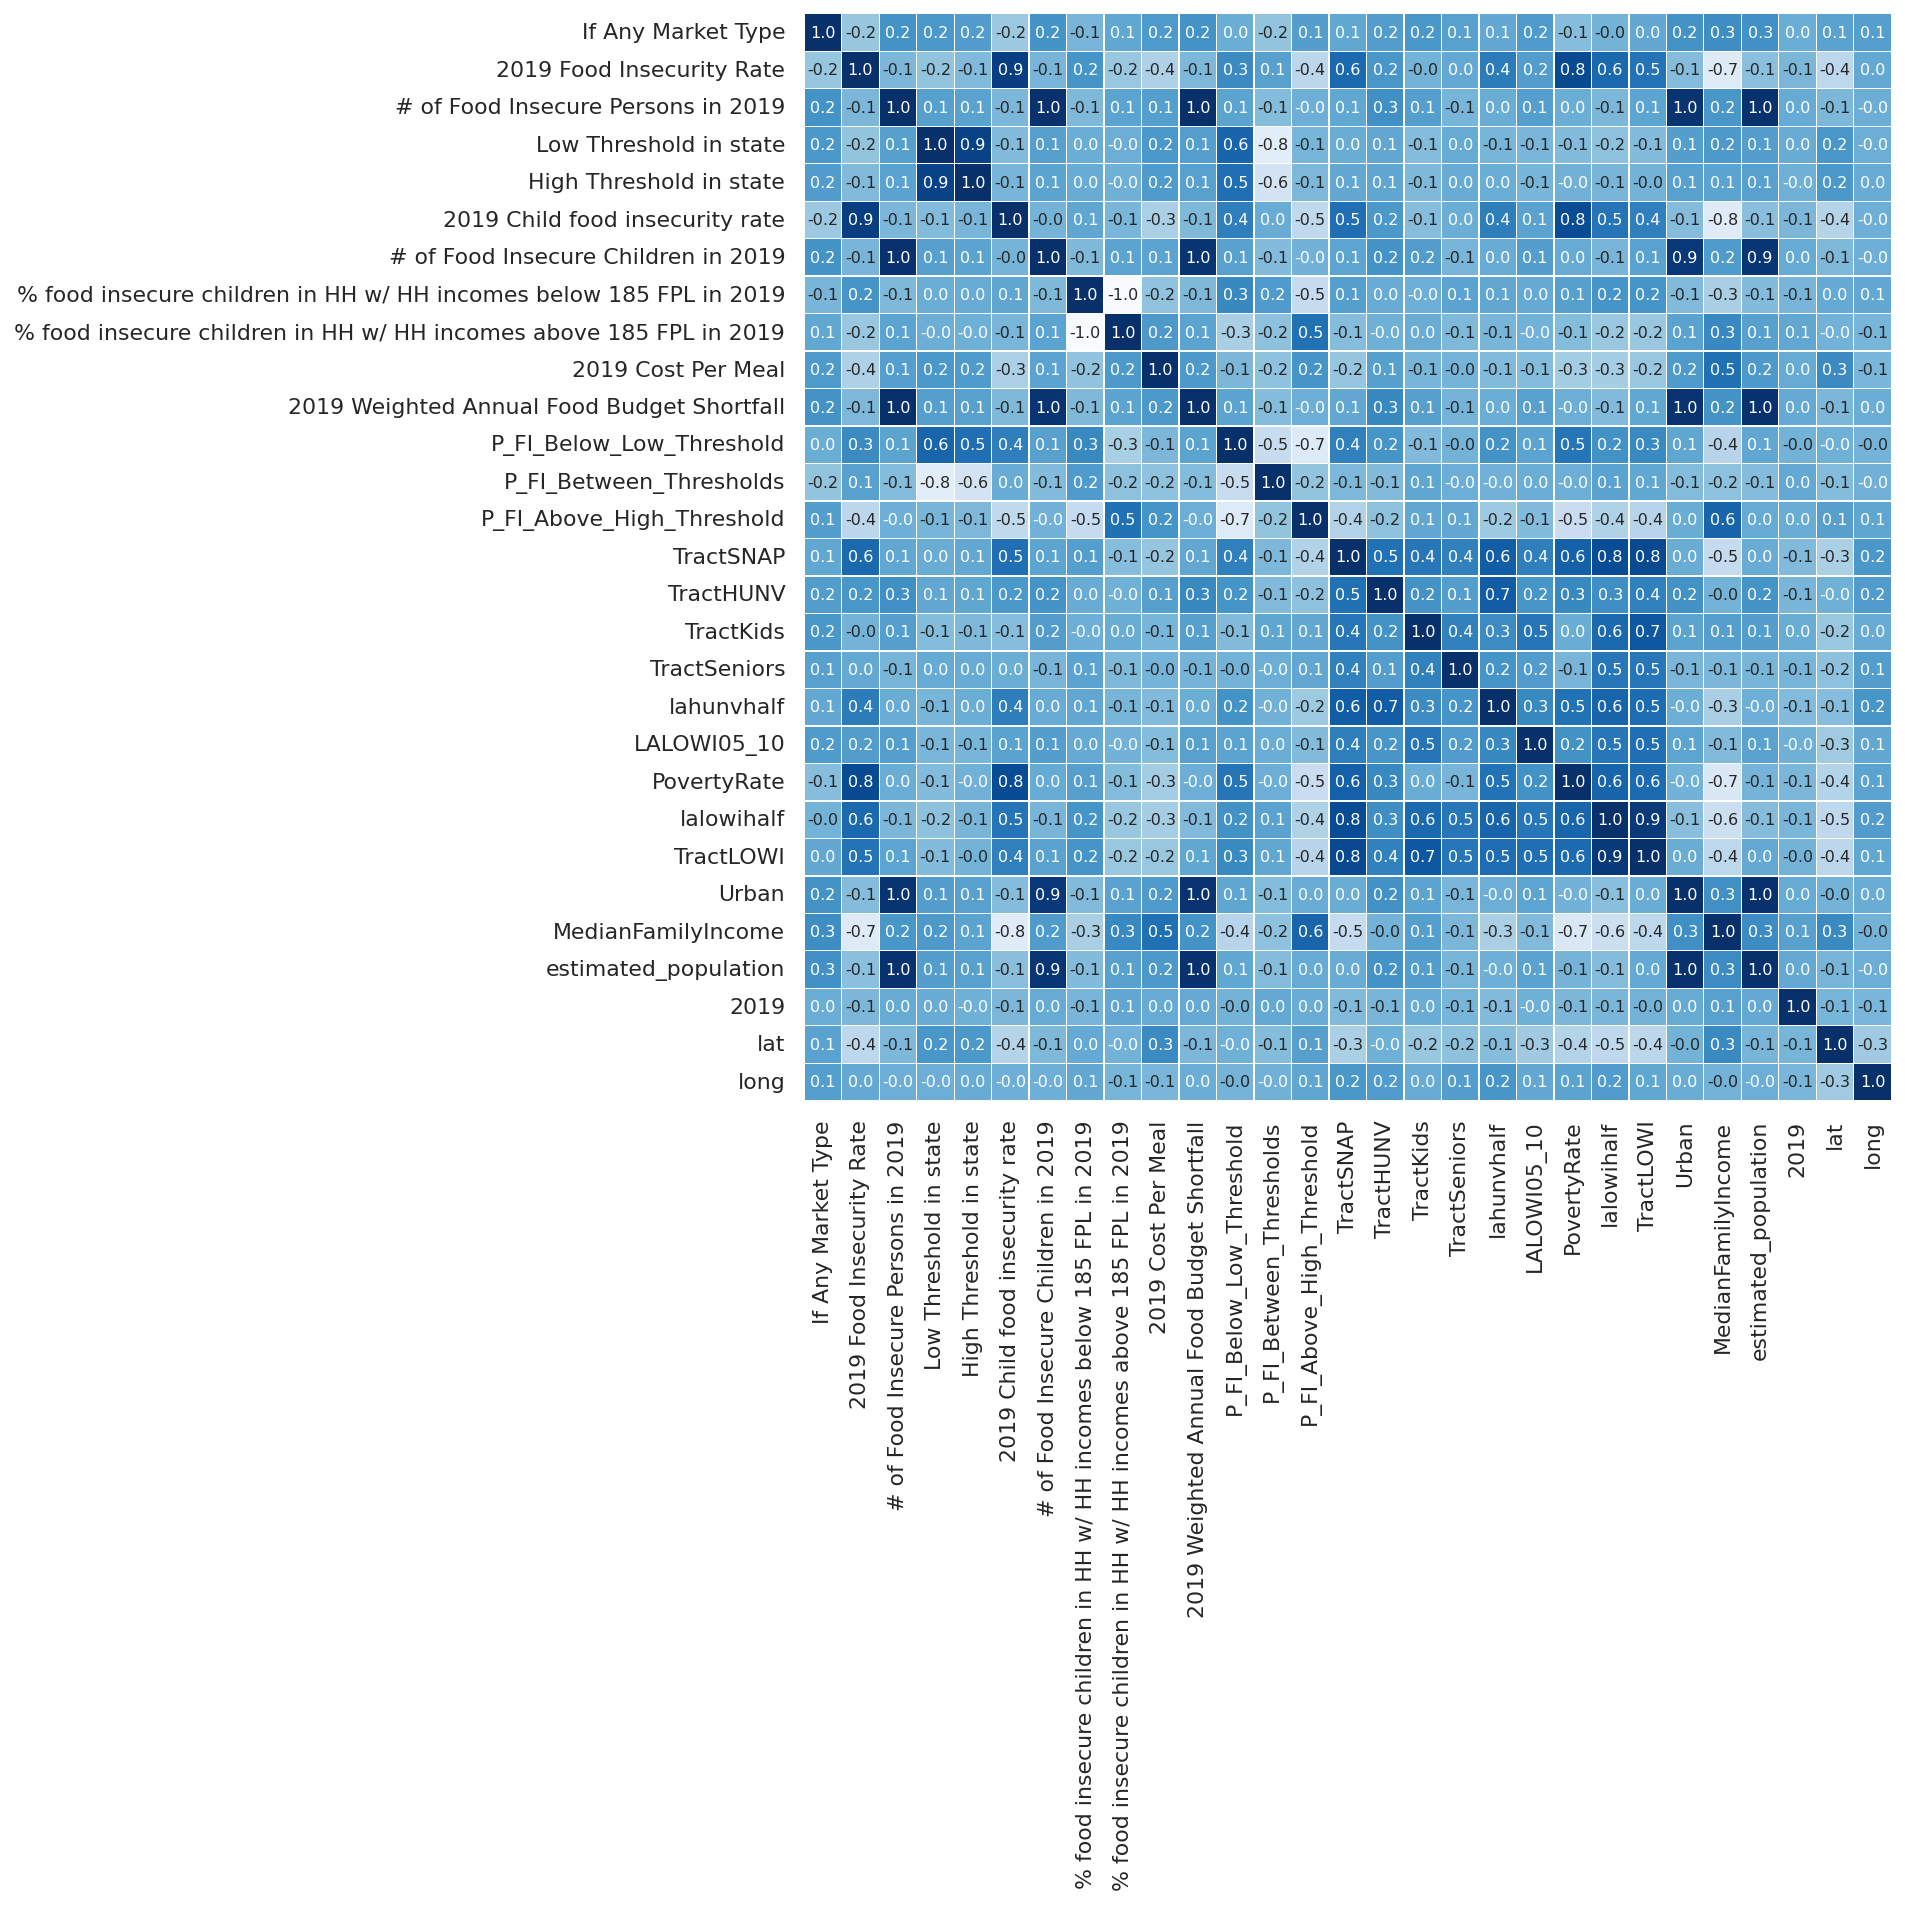

In [20]:
# Plot correlation matrix
set_matplotlib_formats('retina')
plt.figure(figsize = (10,10))
sns.set_theme(style="white")

corr_mat = updated_df_col.corr()

sns.heatmap(corr_mat, cmap = 'Blues', linewidths=0.1,
            annot = True, cbar = False, square = True, fmt=".1f", annot_kws={"size":8})
plt.show()

### Check feature importance

[0.03142519 0.02313564 0.03414932 0.         0.03022966 0.01331172
 0.01706681 0.01683377 0.02164886 0.03247509 0.01416481 0.02136985
 0.02184028 0.01776546 0.02400356 0.01556212 0.01850642 0.01882841
 0.01663555 0.01716191 0.01594287 0.02607195 0.15632458 0.03614055
 0.26569405 0.0167562  0.04805386 0.02890153]


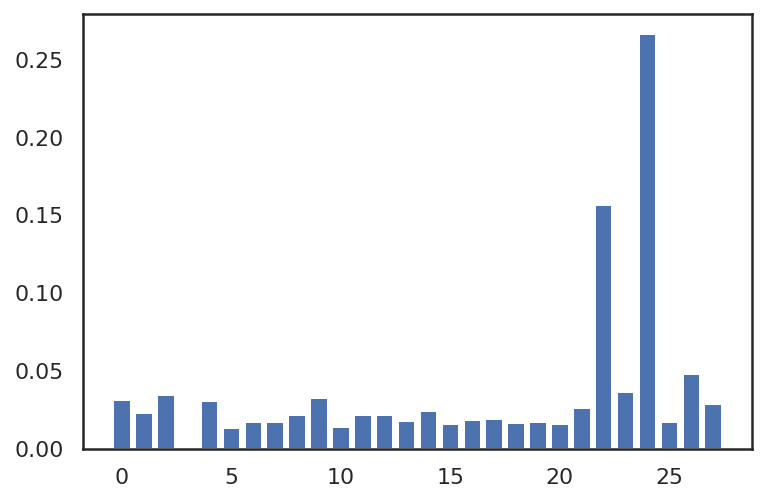

In [11]:
X = updated_df_col.iloc[:, 1:]
y = updated_df_col.iloc[0:,0]


# fit model no training data
model = XGBClassifier()
model.fit(X, y)
print(model.feature_importances_)

# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

<Figure size 576x576 with 0 Axes>

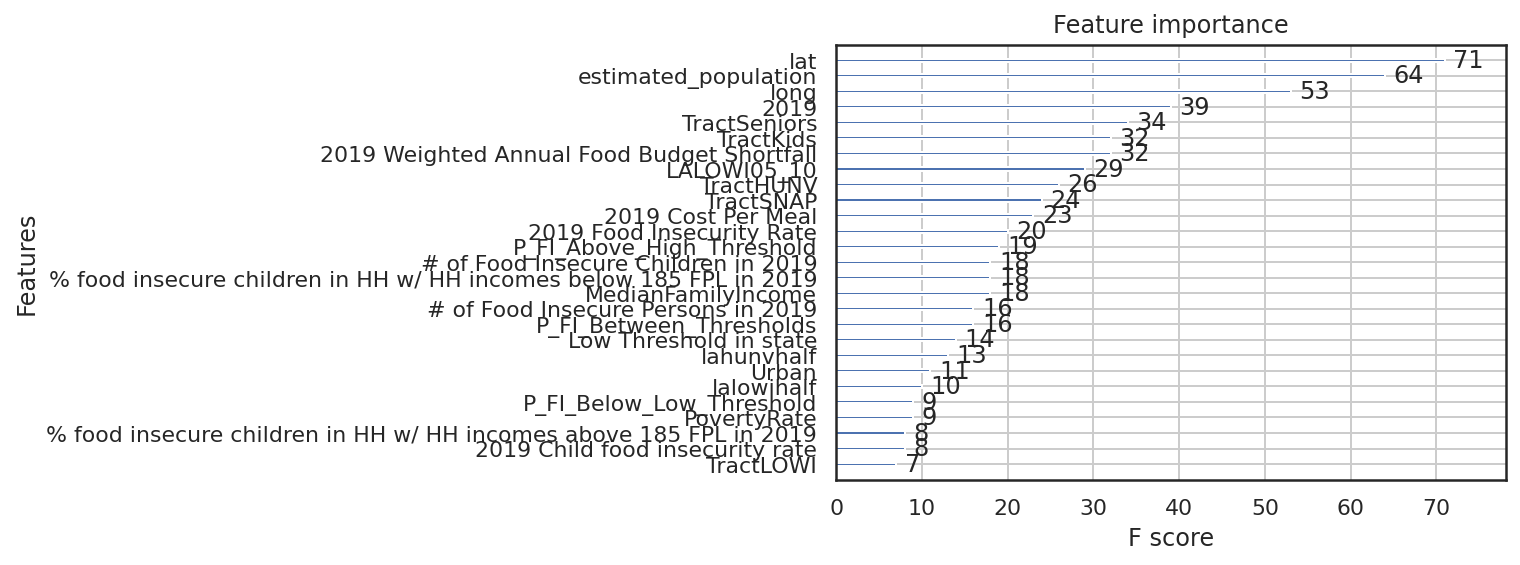

In [12]:

plt.figure(figsize = (8,8))
plot_importance(model)
plt.show()

### Grid Search

In [23]:

# Cross Validation
scaler = StandardScaler()
X = scaler.fit_transform(X)

n = [10, 50, 100]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate, n_estimators = n)

model = XGBClassifier()

# Cross validate
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

#Grid search
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)


# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.491723 using {'learning_rate': 0.1, 'n_estimators': 100}
-0.692823 (0.000030) with: {'learning_rate': 0.0001, 'n_estimators': 10}
-0.691533 (0.000151) with: {'learning_rate': 0.0001, 'n_estimators': 50}
-0.689936 (0.000302) with: {'learning_rate': 0.0001, 'n_estimators': 100}
-0.689935 (0.000303) with: {'learning_rate': 0.001, 'n_estimators': 10}
-0.677709 (0.001407) with: {'learning_rate': 0.001, 'n_estimators': 50}
-0.663703 (0.002648) with: {'learning_rate': 0.001, 'n_estimators': 100}
-0.663563 (0.002645) with: {'learning_rate': 0.01, 'n_estimators': 10}
-0.586971 (0.011082) with: {'learning_rate': 0.01, 'n_estimators': 50}
-0.539530 (0.018527) with: {'learning_rate': 0.01, 'n_estimators': 100}
-0.537644 (0.019129) with: {'learning_rate': 0.1, 'n_estimators': 10}
-0.492466 (0.034817) with: {'learning_rate': 0.1, 'n_estimators': 50}
-0.491723 (0.034438) with: {'learning_rate': 0.1, 'n_estimators': 100}
-0.504617 (0.028338) with: {'learning_rate': 0.2, 'n_estimators': 10}
-0

### Train classifying on best params

In [12]:
# split data into X and y
X = updated_df_col.iloc[:, 1:]
y = updated_df_col.iloc[0:,0]

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# fit model on all training data
model = XGBClassifier(n_estimators=31, eta=0.1, subsample=1, colsample_bytree=0.5)#, random_state = 42)#eta = 0.1, n_estimators = 100, random_state = 42)
model.fit(X_train, y_train)

# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 79.25%


### Test Model

Model:  XGBClassifier(colsample_bytree=0.5, eta=0.1, n_estimators=31)
Whole Dataset Predicted with GDP
log loss 0.47393186079065136
              precision    recall  f1-score   support

         0.0       0.77      0.85      0.81      1695
         1.0       0.79      0.69      0.74      1361

    accuracy                           0.78      3056
   macro avg       0.78      0.77      0.77      3056
weighted avg       0.78      0.78      0.78      3056



<Figure size 576x576 with 0 Axes>

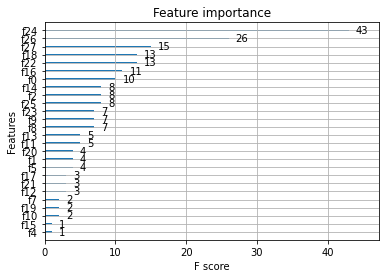

,County,State,probs on whole am,predicted_label_am,If Any Market Type,lat,long
1793,Union County,New Jersey,0.903673,1.0,0.0,40.659871,-74.308696
1998,Cass County,North Dakota,0.902082,1.0,0.0,46.927003,-97.252375
1777,Camden County,New Jersey,0.895640,1.0,0.0,39.802407,-74.961249
371,Pinellas County,Florida,0.884975,1.0,0.0,27.903108,-82.739519
1775,Bergen County,New Jersey,0.871547,1.0,0.0,40.959698,-74.074727
1874,Schenectady County,New York,0.864372,1.0,0.0,42.817552,-74.043559
375,St. Lucie County,Florida,0.861323,1.0,0.0,27.379814,-80.443536
1506,Clay County,Missouri,0.860126,1.0,0.0,39.315551,-94.421502
1530,Jackson County,Missouri,0.841552,1.0,0.0,39.005336,-94.343165
2782,Davis County,Utah,0.830480,1.0,0.0,41.037559,-112.201943


In [13]:
from sklearn.metrics import log_loss
whole_data = True
data_with = 'GDP'
if whole_data == True:
  y_prob = model.predict_proba(X)
  y_pred = model.predict(X)
  print('Model: ', model)
  print(f"Whole Dataset Predicted with {data_with}")
  print("log loss", log_loss(y, y_prob))
  print(classification_report(y, y_pred))
  updated_df['predicted_label_am'] = y_pred
  updated_df['probs on whole am'] = y_prob[:,1]
  prob_whole_fm = updated_df.sort_values(by = 'probs on whole am')[::-1]
  result = prob_whole_fm[['County', 'State', 'probs on whole am', 'predicted_label_am', 'If Any Market Type', 'lat', 'long']].loc[prob_whole_fm['If Any Market Type'] == 0]
  plt.figure(figsize = (8,8))
  plot_importance(model)
  plt.show()

else:
  y_pred = model.predict(X_test)
  y_prob = model.predict_proba(X_test)
  print('Model: ', model)
  print(f"X Test Dataset Predicted with {data_with}")
  print(classification_report(y_test, y_pred))
  print("log loss", log_loss(y_test, y_prob))
  updated_df['predicted_label_AM'] = updated_df.index.map(dict(zip(y_test.index, y_pred)))
  updated_df['probabilities_any_market'] = updated_df.index.map(dict(zip(y_test.index, y_prob[:,1])))
  prob_am = updated_df[['predicted_label_AM','probabilities_any_market', 'County', 'State', 'If Any Market Type', 'lat', 'long']].dropna().sort_values(by = 'probabilities_any_market')[::-1]
  result = prob_am.loc[prob_am['If Any Market Type'] == 0]
  plt.figure(figsize = (8,8))
  plot_importance(model)
  plt.show()
result.head(50)

### Visualize the results
Predicted markets when there isnt any

In [ ]:
# Get results of positive prediction
result = result.loc[result['predicted_label_am'] == 1.0]

In [18]:
import folium
import re

m = folium.Map(location=[result.lat.mean(), result['long'].mean()], 
               zoom_start=4, 
               tiles='cartodbpositron'
               )
for i, row in result.iterrows():
  if row['probs on whole am'] >= .8:
            cluster_color = '#e24a33',
            radius_dot = 2
  else:
    cluster_color = '#BEBEBE'
    radius_dot = .15
    #print(cluster_color, row['clusters'])
  folium.CircleMarker(
          location=[row.lat, row['long']],
          radius=radius_dot,
          popup=re.sub(r'[^a-zA-Z ]+', '', row.County),
          color=cluster_color,
          fill=True,
          opacity=1,
          fill_color=cluster_color
      ).add_to(m)

m

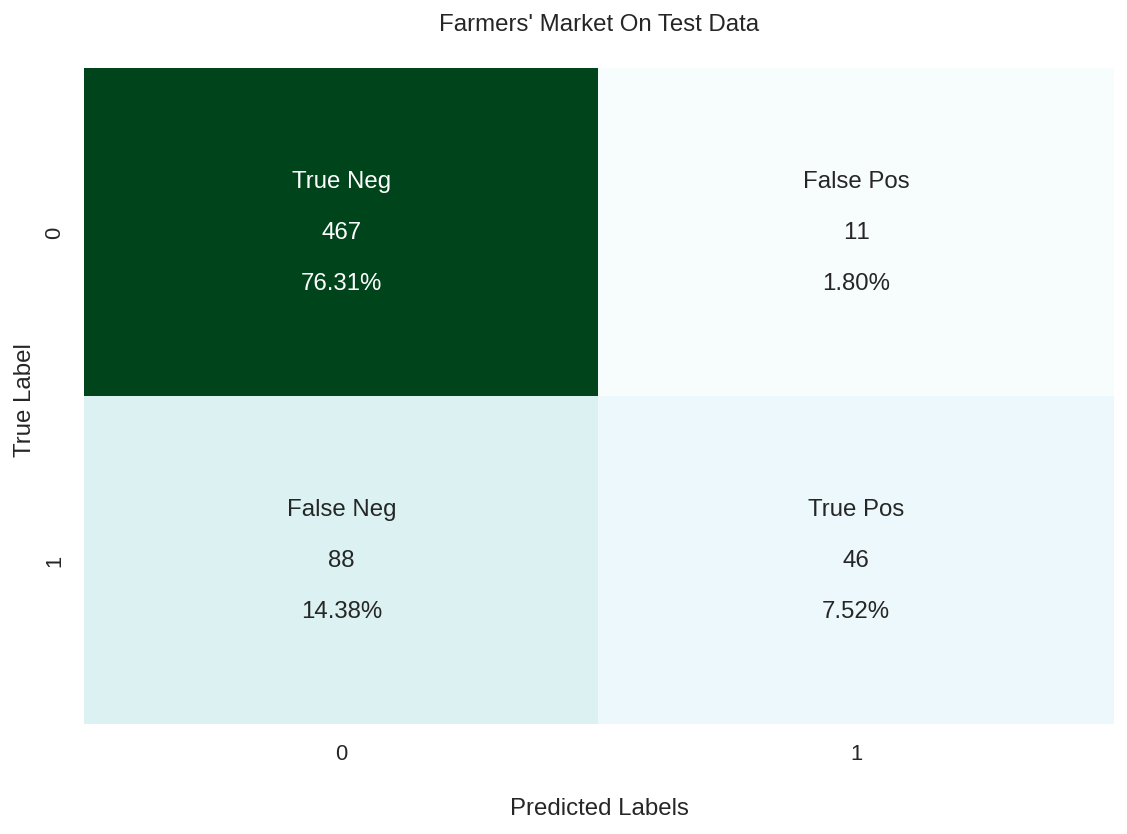

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

set_matplotlib_formats('retina')
plt.figure(figsize = (8,6))
#sns.set_theme(style="white")

# Create the confusion matrix
cm_t = confusion_matrix(y_testf, y_predf)

# Create the confusion matrix 
#cm_tad = confusion_matrix(metrics_ad['y_t'][0], metrics_ad['test_preds'][0])

# Add Annotations inside the plot
cm_mat = [(cm_t, 'On Test Data', "Farmers' Market"), 
          #(cm_tad, 'On Test Data', "Farmers' Markets")
          ]

for cm, name, group_type in cm_mat:
  rate_names = ['True Neg','False Pos','False Neg','True Pos']

  rate_values = ["{0:0}".format(value) for value in cm.flatten()]

  percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

  labels = [f"{val1}\n\n{val2}\n\n{val3}" for val1, val2, val3 in
            zip(rate_names,rate_values,percentages)]

  labels = np.asarray(labels).reshape(2,2)

  ax = sns.heatmap(cm, annot=labels, fmt='', cmap='BuGn', cbar=False,)
                   #yticklabels=['False', 'True'], xticklabels=['False', 'True'])

  # Change the style of plot
  plt.style.use('seaborn-darkgrid')
  ax.set_title(f'{group_type} {name}\n');
  ax.set_xlabel('\nPredicted Labels')
  ax.set_ylabel('True Label ');

  plt.tight_layout()
  plt.savefig(f'/content/gdrive/MyDrive/FIS/images/{group_type}_{name}_Conf matrix.png', dpi = 200)
  plt.show()

All Market F1 and AUC Scores: f1=72.57% auc=83.834% 

Farmers' Market F1 and AUC Scores: f1=48.168% auc=60.391% 



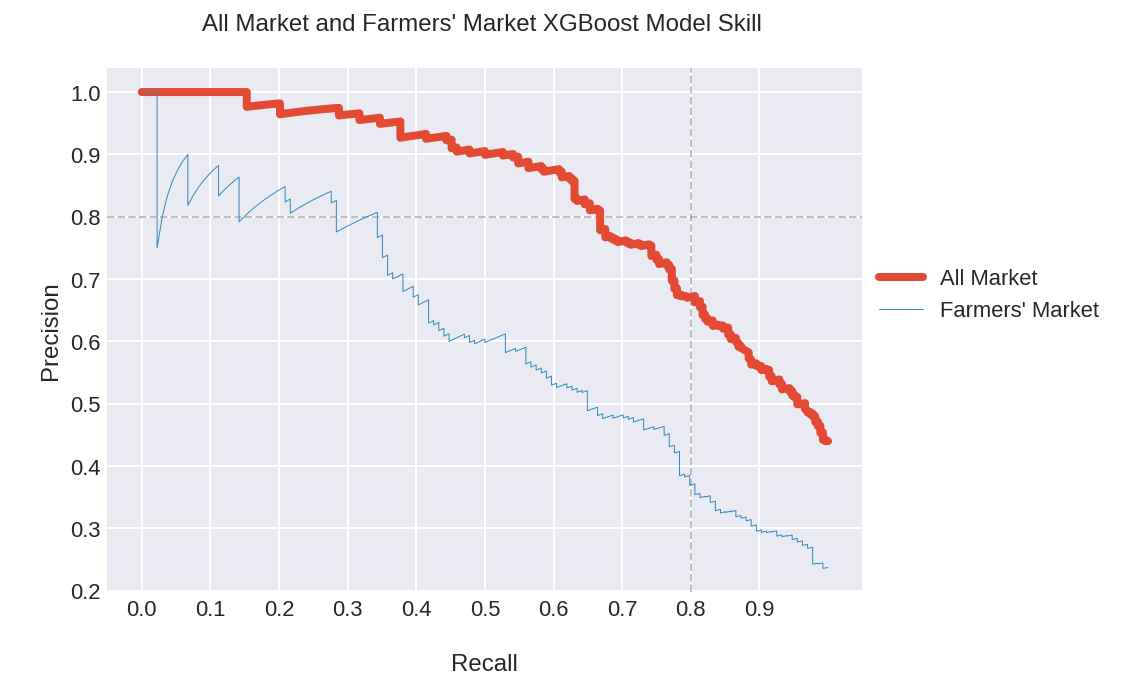

In [40]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

set_matplotlib_formats('retina')
fig = plt.figure(figsize = (8, 5))

# Change the style of plot
plt.style.use('seaborn-darkgrid')

# PR and F1, AUC
pr, re, _ = precision_recall_curve(y_test, 
                                   y_prob[:,1]
                                  )
f1, auc_ = f1_score(y_test,y_pred), auc(re, pr)


prf, ref, _ = precision_recall_curve(y_testf, 
                                   y_probf[:,1]
                                  )
f1f = f1_score(y_testf, y_predf)
aucf_ = auc(ref, prf)

# summarize scores
print(f'All Market F1 and AUC Scores: f1={f1 * 100:{.5}}% auc={auc_ * 100:{.5}}% \n')
print(f"Farmers' Market F1 and AUC Scores: f1={f1f * 100:{.5}}% auc={aucf_ * 100:{.5}}% \n")
# plot the precision-recall curves
plt.axhline(0.8, c='gray', ls="--", lw=1, alpha=0.5)
plt.axvline(0.8, c='gray', ls="--", lw=1, alpha=0.5)
plt.xticks(np.arange(0.0, 1.0, 0.1))
ax.yaxis.set_ticks(np.arange(0.0, 1.0, 0.1))

#All Farmer or All Market
plt.plot(re, pr, marker='', label='All Market', color = '#e24a33', lw = 4)
plt.plot(ref,prf,  marker='', label="Farmers' Market", color = "#348abd", lw = 0.5)

# axis labels
plt.xlabel('\nRecall')
plt.ylabel('\nPrecision')
plt.title("All Market and Farmers' Market XGBoost Model Skill \n")

# show the legend
#plt.legend(loc = "lower left")
lgd = plt.legend(loc=(1.01, 0.5))
plt.savefig(f'/content/gdrive/MyDrive/FIS/images/market_Precision_Recall.png', 
            dpi =200,
            bbox_extra_artists=(lgd,), 
            bbox_inches='tight')
plt.tight_layout()

[0]	validation_0-logloss:0.645154	validation_1-logloss:0.646223
[1]	validation_0-logloss:0.604139	validation_1-logloss:0.606428
[2]	validation_0-logloss:0.574853	validation_1-logloss:0.581192
[3]	validation_0-logloss:0.545536	validation_1-logloss:0.555005
[4]	validation_0-logloss:0.524344	validation_1-logloss:0.536004
[5]	validation_0-logloss:0.502604	validation_1-logloss:0.513931
[6]	validation_0-logloss:0.484293	validation_1-logloss:0.497722
[7]	validation_0-logloss:0.468511	validation_1-logloss:0.484289
[8]	validation_0-logloss:0.454856	validation_1-logloss:0.473278
[9]	validation_0-logloss:0.443121	validation_1-logloss:0.462005
[10]	validation_0-logloss:0.433033	validation_1-logloss:0.454446
[11]	validation_0-logloss:0.424446	validation_1-logloss:0.448134
[12]	validation_0-logloss:0.417046	validation_1-logloss:0.441957
[13]	validation_0-logloss:0.410707	validation_1-logloss:0.436709
[14]	validation_0-logloss:0.404649	validation_1-logloss:0.43248
[15]	validation_0-logloss:0.399634	v

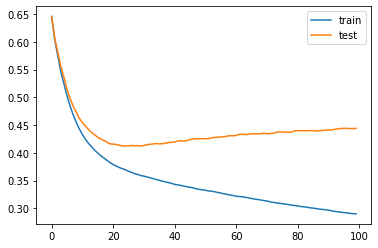

In [15]:
model = XGBClassifier(n_estimators=100, eta=0.1, subsample=.8, colsample_bytree=0.3)
evalset = [(X_trainf, y_trainf), (X_testf,y_testf)]
# fit the model
model.fit(X_trainf, y_trainf, eval_metric='logloss', eval_set=evalset)
# evaluate performance
yhatf = model.predict(X_testf)
score = accuracy_score(y_testf, yhatf)
print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

